# Ejercicio 2

## Filtro de Bayer

Los datos brutos del sensor de una cámara fotográfica generalmente vienen en forma de una matriz de filtros de color (CFA). Se trata de una matriz de píxeles m-por-n (donde m y n son las dimensiones del sensor) donde cada píxel lleva información sobre un solo canal de color: rojo, verde o azul.

El patrón CFA más común es la matriz, filtro, máscara o mosaico de Bayer, la cual se llama así por su creador, Bryce Bayer, de la empresa Eastman Kodak.

El filtro de Bayer está formado por un 50 % de filtros verdes, un 25 % de rojos y un 25 % de azules. Interpolando dos muestras verdes, una roja y una azul, se obtiene un pixel de color. En la patente de Bryce Bayer, se llama elementos sensores de luminosidad a los verdes, y elementos sensores del color a los rojos y azules. La razón de que se use mayor cantidad de puntos verdes es que el ojo humano es más sensible a ese color. 

En la figura a continuación se puede ver una imágen de una matríz de Bayer.

<div align="center">
    <img src='https://i.ibb.co/CvgdxGX/bayer-filter.png' alt="elementos estructurales" width="400">
      <h5 align="center">
          Figura 1: Matríz de Bayer.
      </h5>
    <br>
</div>

En los ficheros RAW de las cámaras de fotos digitales se guarda la información del patrón de Bayer de forma directa, sin interpolaciones, lo cual puede ser aprovechado posteriormente por los programas de revelado digital para una decodificación de mayor calidad que la que permiten los algoritmos internos presentes en los dispositivos de captura.

## Demosaicing

El desbayering, también conocido como demosaicing o algoritmo de interpolación cromática, es el proceso digital para convertir una imagen CFA (m-by-n) en una imagen digital de color RGB verdadero (m-by-n-by-3). Si bien es posible que solo conozca realmente un valor de color en cualquier ubicación de píxel, puede interpolar inteligentemente los otros dos valores de color de los vecinos cercanos donde se conocen esos colores.

## Ejercicio:

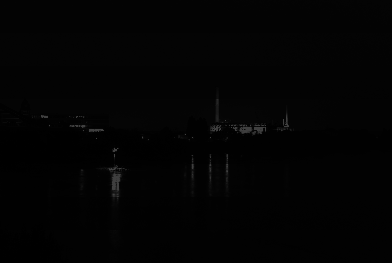

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from IPython.display import clear_output
from helper_file import plot_image, plot_multiple_images 

# 'black': the black point in the RAW image
black = 0
# 'saturation': This is the value at which the sensor can no longer produce any higher values.
# This is _not_ anything to do with 'saturation' in terms of color spaces, e.g., HSV color space.
saturation = 16383  
# 'wb_multipliers': white balance multipliers for each of the R, G, B channels
# It is very important that green (the middle one) is the one that stays at 1, because then we use that.
wb_multipliers = [2.217041, 1.000000, 1.192484] 

# Use the output file from command "dcraw -4 -D -T <raw_file_name>"

# Here a description of the values -4, -D and -T

# The camera may apply non-linear transformations to the sensor data for memory reasons.
# then the -4 comes to save us because it takes care of the linearization for us.
# -T we need it to tell you to write the output file as TIFF instead of PPM
# and finally we need the -D to enable the document mode that takes care of not scaling (purely RAW).

# Then we open the file created.
raw_data = Image.open('../assets/sample.tiff')

# The values inside the array are cast 
raw = np.array(raw_data).astype(np.double)
# The image is shown with the following line, it is scaled only so that
# looks better on the notebook but always works with the image in the original size
display(raw_data.resize((int((np.size(raw_data)[0]/10)),int(np.size(raw_data)[1]/10)), Image.NEAREST))

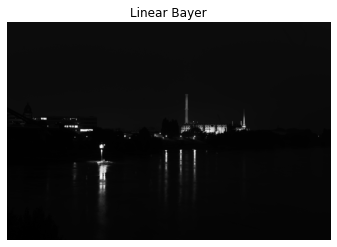

In [2]:
# Step 1: Normalization
# We convert the map into a [0, 1] values map dividing by the maximum value.

linear_bayer = raw / np.amax(raw)
plot_image(linear_bayer, "Linear Bayer", cmap='gray')

In [3]:
def wbscalematrix(m, n, wb_scales, align):
    # Makes a white-balance scaling matrix for an image of size m-by-n
    # from the individual RGB white balance scalar multipliers [wb_scales] = [R_scale G_scale B_scale].
    #
    # [align] is string indicating the 2x2 Bayer arrangement: 
    # 'rggb':  
    #    R G 
    #    G B 
    # 'gbrg':
    #    G B
    #    R G
    # 'grbg':
    #    G R
    #    B G
    # 'bggr':
    #    B G
    #    G R


    # First, for convenience only, we're going to fill the scale matrix
    # with all green pixels. Then, we're going to replace the red and blue 
    # pixels later on with the correct scalars.

    scalematrix = wb_scales[1] * np.ones((m,n)) # Initialize to all green values

    # Fill in the scales for the red and blue pixels across the matrix
    # The next lines uses the cases to known where to put a red and blue pixel. according to the matrix showed recently.
    if (align == 'rggb'):
        scalematrix[0::2, 0::2] = wb_scales[0] # r
        scalematrix[1::2, 1::2] = wb_scales[2] # b
    elif (align == 'bggr'):
        scalematrix[1::2, 1::2] = wb_scales[0] # r
        scalematrix[0::2, 0::2] = wb_scales[2] # b
    elif (align == 'grbg'):
        scalematrix[0::2, 1::2] = wb_scales[0] # r
        scalematrix[0::2, 1::2] = wb_scales[2] # b
    elif (align == 'gbrg'):
        scalematrix[1::2, 0::2] = wb_scales[0] # r
        scalematrix[0::2, 1::2] = wb_scales[2] # b
    return scalematrix

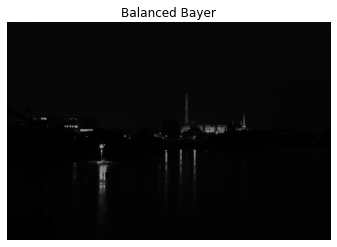

In [4]:
# Step 2: White balancing
mask = wbscalematrix(linear_bayer.shape[0], linear_bayer.shape[1], wb_multipliers, 'rggb')
balanced_bayer = np.multiply(linear_bayer, mask)
plot_image(balanced_bayer, "Balanced Bayer", cmap='gray')

In [5]:
def apply_cmatrix(img, cmatrix):
    # Applies color transformation CMATRIX to RGB input IM. 
    # Finds the appropriate weighting of the old color planes to form the new color planes, 
    # equivalent to but much more efficient than applying a matrix transformation to each pixel.
    if (img.shape[2] != 3):
        raise ValueError('Apply cmatrix to RGB image only.')

    r = cmatrix[0,0] * img[:,:,0] + cmatrix[0,1] * img[:,:,1] + cmatrix[0,2] * img[:,:,2]
    g = cmatrix[1,0] * img[:,:,0] + cmatrix[1,1] * img[:,:,1] + cmatrix[1,2] * img[:,:,2]
    b = cmatrix[2,0] * img[:,:,0] + cmatrix[2,1] * img[:,:,1] + cmatrix[2,2] * img[:,:,2]
    corrected = np.stack((r,g,b), axis=2)
    return corrected

In [6]:
# To conceptualize how this works, let's continue to draw some information.
def drawit(old_g, filter_g, g):
    print("old g:")
    print(old_g[0:4:1,0:4:1])
    print("filter:")
    print(filter_g)
    print("output:")
    print(g[0:4:1,0:4:1]) 
    # The filter only produces output if the surrounding pixels match its pattern.
    # When they do, it produces their mean value. It does the average the horizontal and 
    # vertical neighbors (that is, add the ones you have and always divide them by 4).

    # Note that we're going to have some incorrect values at the image boundaries, 
    # but let's ignore that.

In [7]:
def debayering(input):
    # Bilinear Interpolation of the missing pixels
    #
    # Assumes a Bayer CFA in the 'rggb' layout
    #   R G R G
    #   G B G B
    #   R G R G
    #   G B G B
    #
    # Input: Single-channel rggb Bayered image
    # Returns: A debayered 3-channels RGB image
    #
    
    #Load the image as double values.
    img = input.astype(np.double)

    # get the image's size.    
    m = img.shape[0]
    n = img.shape[1]
    
    print("the image has " + str(m) + " x " + str(n) + " pixeles")

    # First, we're going to create indicator masks that tell us
    # where each of the color pixels are in the bayered input image
    # 1 indicates presence of that color, 0 otherwise
    red_mask = np.tile([[1,0],[0,0]], (int(m/2), int(n/2)))
    print("the red mask is:")
    print(red_mask)
    print("red mask's size:" + str(red_mask.shape))

    # indicator masks for the green and blue channels are shown next.
    
    green_mask = np.tile([[0,1],[1,0]], (int(m/2), int(n/2)))
    blue_mask = np.tile([[0,0],[0,1]], (int(m/2), int(n/2))) 

    r = np.multiply(img, red_mask)
    g = np.multiply(img, green_mask)
    b = np.multiply(img, blue_mask)

    # Next, we're going to fill in the missing values in r,g,b
    # For this, we're going to use filtering - convolution - to implement bilinear interpolation.
    # - We know that convolution allows us to perform a weighted sum
    # - We know _where_ our pixels lie within a grid, and where the missing pixels are
    # - We know filters come in odd sizes
    old_g = g
    # Interpolating green:
    filter_g = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_g = convolve2d(g, filter_g, 'same')
    g = g + missing_g

    # To conceptualize how this works, let's continue to draw it out on paper to show it uncomment this line
    # drawit(old_g, filter_g, g)

   
    # Now, let's try it for blue. This one is a two-step process.
    # - Step 1: We fill in the 'central' blue pixel in the location of the red pixel
    # - Step 2: We fill in the blue pixels at the locations of the green pixels, 
    #           similar to how the green interpolation worked, but offset by a row/column
   
    # Interpolating blue:
    # Step 1:
    filter1 = 0.25 * np.array([[1,0,1],[0,0,0],[1,0,1]])
    missing_b1 = convolve2d(b, filter1, 'same')
    # Step 2:
    filter2 = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_b2 = convolve2d(b + missing_b1, filter2, 'same')
    b = b + missing_b1 + missing_b2

    # Only red left. 
    # Interpolation for the red at the missing points
    # First with blue
    filter1 = 0.25 * np.array([[0,0,0],[0,1,0],[0,0,0]])
    missing_r1 = convolve2d(r, filter1, 'same')
    # Step 2:
    # Then with green
    filter2 = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_r2 = convolve2d(r + missing_r1, filter2, 'same')
    r = r + missing_r1 + missing_r2

    output = np.stack((r,g,b), axis=2)
    return output


the image has 2638 x 3920 pixeles
the red mask is:
[[1 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
red mask's size:(2638, 3920)


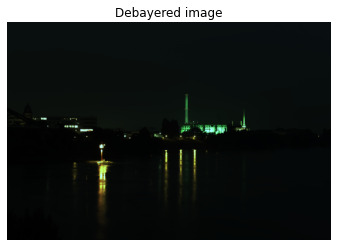

In [8]:
# Step 3: Here we run the Debayering funtion (also called demosaicing)
lin_rgb = debayering(balanced_bayer)
plot_image(lin_rgb, "Debayered image")

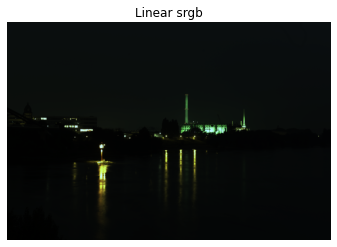

In [9]:
# Step 4: Color space conversion
# Caution if you wish to use your own RAW image from a custom camera model, 
# you need to find out the XYZ-to-camera matrix for your camera model. 

rgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
                   [0.2126729, 0.7151522, 0.0721750],
                   [0.0193339, 0.1191920, 0.9503041]])
xyz2cam = np.array([[0.6653, -0.1486, -0.0611],
                    [-0.4221, 1.3303, 0.0929],
                    [-0.0881, 0.2416, 0.7226]])
# Assuming previously defined matrices
rgb2cam = xyz2cam * rgb2xyz 
denom = np.tile(np.reshape(np.sum(rgb2cam,axis=1),(3,-1)), (1,3))
# Normalize rows to 1
rgb2cam = np.divide(rgb2cam, denom) 
cam2rgb = np.linalg.inv(rgb2cam)
lin_srgb = apply_cmatrix(lin_rgb, cam2rgb)
# Always keep image clipped b/w 0-1
lin_srgb[lin_srgb > 1.0] = 1.0 
lin_srgb[lin_srgb < 0.0] = 0.0
plot_image(lin_srgb, "Linear srgb")

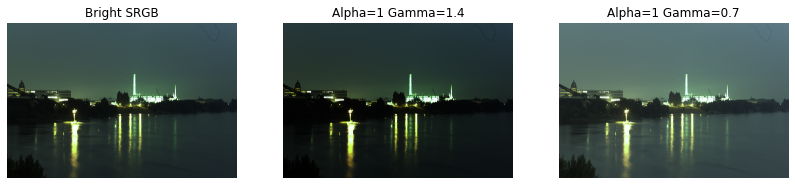

In [12]:
# Step 5: Brightness and gamma correction
# Feel free to modify the consts to get the best result according to your image.
# We choose some values using the same criteria as the proposed website, 
# but also test the code with diferent values of alpha and gamma.
print("Wait a moment this process can take a while")
print("0/3 completed")
bright_srgb = lin_srgb * (lin_srgb.max() * 1/4.0 / lin_srgb.mean()) 

clear_output(wait=True)
print("Wait a moment this process can take a while")
print("1/3 completed")



alpha = 1
gamma = 1.4

nl_srgb = alpha*bright_srgb**gamma

clear_output(wait=True)
print("Wait a moment this process can take a while")
print("2/3 completed")



alpha = 1
gamma = 0.7

nl_srgb2 = alpha*bright_srgb**gamma

clear_output(wait=True)
print("Wait a moment this process can take a while")
print("3/3 completed")
print("Wait a moment while it get printed")

plot_multiple_images(bright_srgb,"Bright SRGB",nl_srgb,"Alpha=1 Gamma=1.4",nl_srgb2,"Alpha=1 Gamma=0.7")
clear_output(wait=True)

## Conclusiones

Podemos ver que luego del procesamiento de la imágen en bruto pudimos llegar a imágenes en color que se pueden ver con una calidad aceptable y donde la imágen se puede modificar según el caso basándose en los valores de alpha y gamma que se seleccionen para el caso.